In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib as mpl
from datetime import datetime
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.metrics import mean_absolute_error

In [2]:
df = pd.read_csv('municipality_bus_utilization.csv', header=0,parse_dates=[0])
df.head(5)

,timestamp,municipality_id,usage,total_capacity
0,2017-06-04 07:59:42,9,454,1332
1,2017-06-04 07:59:42,8,556,2947
2,2017-06-04 07:59:42,4,1090,3893
3,2017-06-04 07:59:42,0,204,2813
4,2017-06-04 07:59:42,7,718,2019


In [3]:
df.isnull().sum()       #Check if there is any missing data. Seems to be None

timestamp          0
municipality_id    0
usage              0
total_capacity     0
dtype: int64

In [4]:
del df['total_capacity']   #Dropping Total Capacity column

# Baseline Model (Naive Forecast Model)

MSE for Municipality 0: 11955.197183098591
MAE for Municipality 0: 66.25352112676056


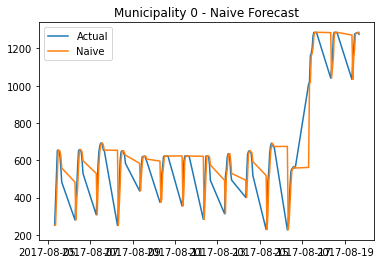

MSE for Municipality 1: 5959.077464788732
MAE for Municipality 1: 46.24647887323944


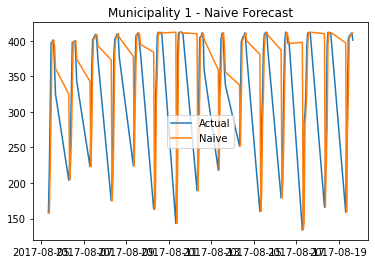

MSE for Municipality 2: 7808.894366197183
MAE for Municipality 2: 64.75352112676056


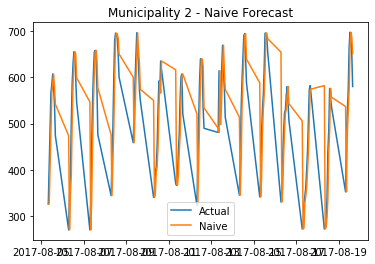

MSE for Municipality 3: 55370.528169014084
MAE for Municipality 3: 163.1338028169014


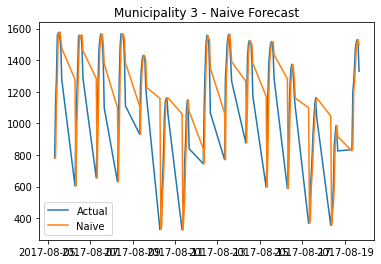

MSE for Municipality 4: 233728.58450704225
MAE for Municipality 4: 324.6267605633803


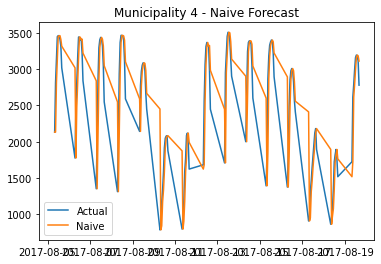

MSE for Municipality 5: 5868.169014084507
MAE for Municipality 5: 51.25352112676056


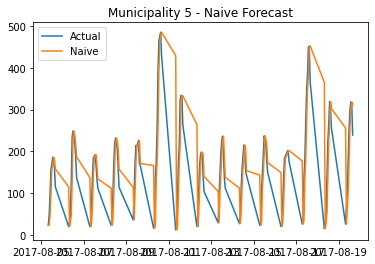

MSE for Municipality 6: 23058.549295774646
MAE for Municipality 6: 106.21126760563381


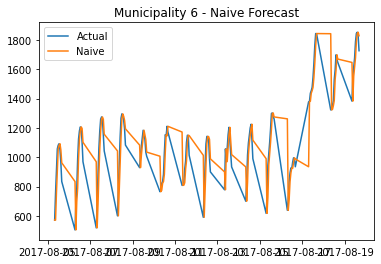

MSE for Municipality 7: 53201.894366197186
MAE for Municipality 7: 162.8943661971831


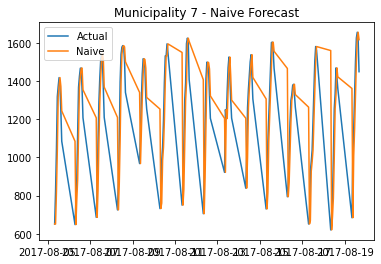

MSE for Municipality 8: 41183.626760563384
MAE for Municipality 8: 131.66901408450704


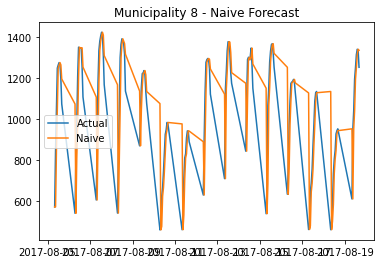

MSE for Municipality 9: 21946.140845070422
MAE for Municipality 9: 101.1830985915493


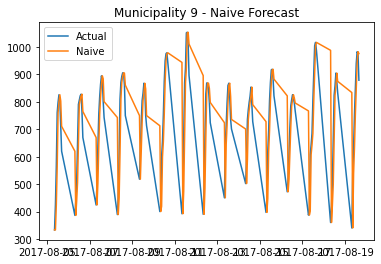

In [5]:
def Naive_Model(dataframe, municipality_id):
    
    municipality_data = dataframe[dataframe['municipality_id'] == municipality_id]
    municipality_data_hourly = municipality_data.groupby(['municipality_id',
                                            pd.Grouper(key='timestamp',freq='H')])['usage'].max().reset_index()
    
    municipality_data_hourly.set_index('timestamp', inplace=True)
    municipality_data_hourly.sort_index(inplace=True)
    
    train_data = municipality_data_hourly[municipality_data_hourly.index < datetime(2017, 8, 5)]
    test_data = municipality_data_hourly[municipality_data_hourly.index >= datetime(2017, 8, 5)]
    
    train_X = train_data['usage'].shift(1)
    train_X[0] = train_data['usage'][0]               # Naive forecast model
    train_y = train_data['usage']
    
    test_X = test_data['usage'].shift(1)
    test_X[0] = test_data['usage'][0] 
    test_y = test_data['usage']
    
    preds = test_X.copy()
    
    MSE = mean_squared_error(test_y, preds)
    MAE = mean_absolute_error(test_y, preds)
    
    print(f"MSE for Municipality {municipality_id}:", MSE)
    print(f"MAE for Municipality {municipality_id}:", MAE)
    
    plt.plot(np.array(test_data.index), np.array(test_y), label='Actual')
    plt.plot(np.array(test_data.index), np.array(preds), label='Naive')
    plt.title(f'Municipality {municipality_id} - Naive Forecast')
    plt.legend()
    plt.show()
    

municipalities = range(df['municipality_id'].max() + 1)
for mun in municipalities:
    Naive_Model(df,mun)

# ARIMA Model

In [10]:
from statsmodels.tsa.arima.model import ARIMA

In [13]:
from statsmodels.tsa.stattools import adfuller

def ad_test(dataset):
    dftest = adfuller(dataset, autolag = 'AIC')
    print("1. ADF : ",dftest[0])
    print("2. P-Value : ", dftest[1])
    print("3. Num Of Lags : ", dftest[2])
    print("4. Num Of Observations Used For ADF Regression:", dftest[3])
    print("5. Critical Values :")
    for key, val in dftest[4].items():
        print("\t",key, ": ", val)
        
ad_test(df['usage'])   #Checking the value of P: it's very less so we can confirm that the trend is stationary

1. ADF :  -11.633527571168402
2. P-Value :  2.2329301100745062e-21
3. Num Of Lags :  41
4. Num Of Observations Used For ADF Regression: 13028
5. Critical Values :
	 1% :  -3.43085204090602
	 5% :  -2.861761877895934
	 10% :  -2.56688810067643


In [16]:
from pmdarima import auto_arima
stepwise_fit = auto_arima(df['usage'], trace=True, suppress_warnings=True)  # Best model is (2, 1, 2)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=206519.463, Time=20.20 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=215939.771, Time=0.30 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=212309.604, Time=0.54 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=206888.757, Time=3.55 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=215937.771, Time=0.14 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=206569.278, Time=17.76 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=206801.114, Time=10.17 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=206574.916, Time=23.13 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=206898.375, Time=17.83 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=206861.732, Time=6.69 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=206521.408, Time=23.09 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=206742.277, Time=14.83 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=40.99 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=206517.468, Time=4.18 sec
 ARI

RMSE for Municipality 0: 309.1382442122917
RMSE for Municipality 1: 82.04552829767613
RMSE for Municipality 2: 130.22124926459404
RMSE for Municipality 3: 346.41771365810104
RMSE for Municipality 4: 790.5601923493773
RMSE for Municipality 5: 124.45023334194919
RMSE for Municipality 6: 303.74140063422334
RMSE for Municipality 7: 275.82346926088746
RMSE for Municipality 8: 274.67493258301835
RMSE for Municipality 9: 191.7103149595237


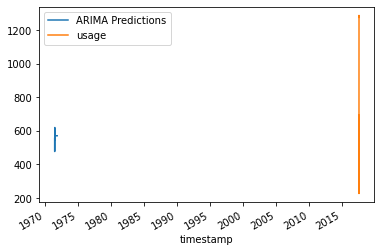

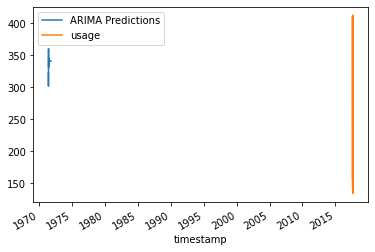

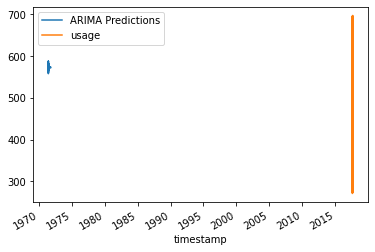

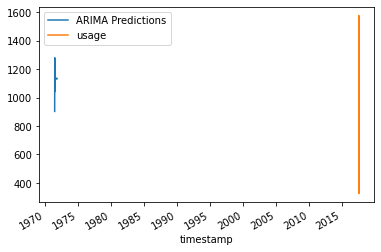

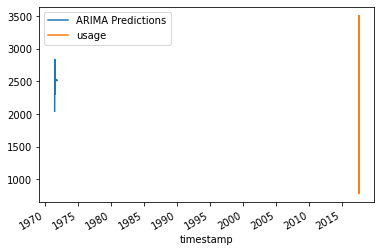

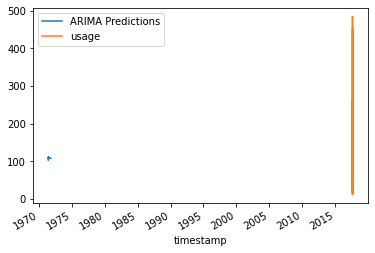

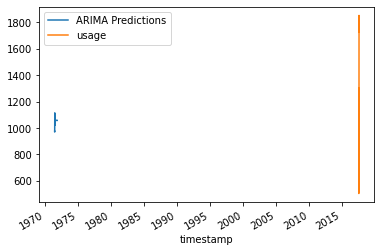

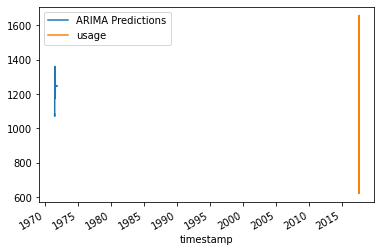

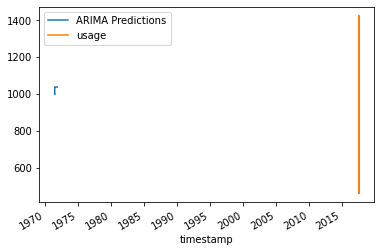

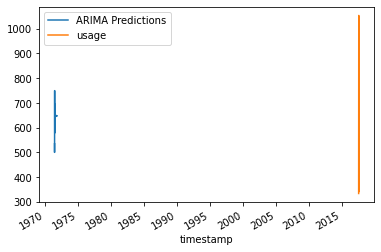

In [22]:
import warnings
warnings.filterwarnings('ignore')


def model_ARIMA(dataframe, municipality_id):
    
    municipality_data = dataframe[dataframe['municipality_id'] == municipality_id]
    municipality_data_hourly = municipality_data.groupby(['municipality_id',
                                            pd.Grouper(key='timestamp',freq='H')])['usage'].max().reset_index()
    
    municipality_data_hourly.set_index('timestamp', inplace=True)
    municipality_data_hourly.sort_index(inplace=True)
    
    train_data = municipality_data_hourly[municipality_data_hourly.index < datetime(2017, 8, 5)]
    test_data = municipality_data_hourly[municipality_data_hourly.index >= datetime(2017, 8, 5)]
    
    model0= ARIMA(train_data['usage'],order=(2,1,2))
    model0= model0.fit()
    model0.summary()
    
    start = len(train_data)
    end = len(train_data)+len(test_data)-1
    pred = model0.predict(start=start,end=end,typ='levels').rename('ARIMA Predictions')
    
    fig, ax = plt.subplots()
    pred.plot(legend=True, ax=ax)
    test_data['usage'].plot(legend=True, ax=ax)
    
    test_data['usage'].mean()
    rmse = sqrt(mean_squared_error(pred, test_data['usage']))
    print(f"RMSE for Municipality {municipality_id}:", rmse)

    
for mun in municipalities:
    model_ARIMA(df, mun)